# import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
import matplotlib.pyplot as plt

# put your data in "data" repository
there are three repositories (normal, abnormal), put each image in suitable repository

In [2]:
os.listdir('./data/')

['normal', 'abnormal']

# train your model

Stick to this size as an input to the model

In [3]:
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    './data/',
    batch_size=32,
    subset='training',
    labels='inferred',
    label_mode="binary",
    color_mode="rgb",
    image_size=(img_height, img_width),
    validation_split=0.2,
    seed=48
)

Found 2076 files belonging to 2 classes.
Using 1661 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    './data/',
    batch_size=32,
    subset='validation',
    labels='inferred',
    label_mode="binary",
    color_mode="rgb",
    image_size=(img_height, img_width),
    validation_split=0.2,
    seed=48
)

Found 2076 files belonging to 2 classes.
Using 415 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['abnormal', 'normal']


TypeError: only integer scalar arrays can be converted to a scalar index

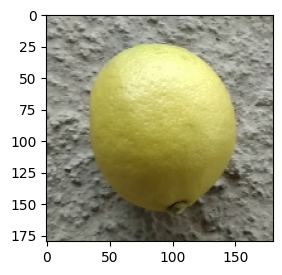

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])

In [12]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

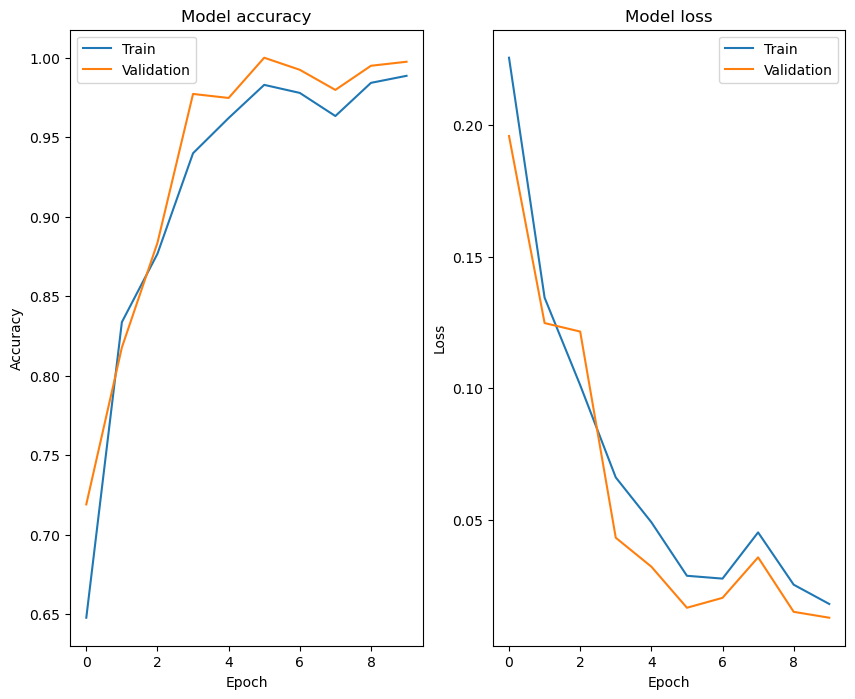

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

# Accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'])

# Loss
axs[1].plot(history.history['loss']) 
axs[1].plot(history.history['val_loss']) 
axs[1].set_title('Model loss') 
axs[1].set_ylabel('Loss') 
axs[1].set_xlabel('Epoch') 
axs[1].legend(['Train', 'Validation']) 

In [31]:
from tensorflow.keras.preprocessing import image

path = os.path.join('data/normal', 'good_quality_1.jpg')
img = image.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

print(predictions[0][0])

1/1 [==============================] - 0s 61ms/step
1.1317271


# save your model

In [ ]:
model.save('../models/your_model_name')

# reload your model and use with your cam

In [9]:
reloaded_model = tf.keras.models.load_model('../models/lemon_quality')

In [10]:
from tensorflow.keras.preprocessing import image

path = os.path.join('data/normal', 'good_quality_1.jpg')
img = image.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = reloaded_model.predict(img_array)
print( "score = ", predictions[0][0])

1/1 [==============================] - 1s 1s/step
score =  1.1317271


Using cv2

In [13]:
import cv2

img = cv2.imread('./data/abnormal/bad_quality_700.jpg')
img = cv2 .resize(img,(180,180))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = tf.expand_dims(img, 0)
predictions = reloaded_model.predict(img)
score = predictions[0][0]
print(score)

1/1 [==============================] - 0s 108ms/step
0.3920807


In [ ]:
import cv2

# remember to select your cam ID
cap = cv2.VideoCapture(1,cv2.CAP_DSHOW)
cap.set(3, 640)
cap.set(4, 480)

model = tf.keras.models.load_model('../models/lemon_quality')
score_threshold = 0.2

def nothing(x):
    pass

cv2.namedWindow("tracking")
cv2.createTrackbar("LH", "tracking", 0, 255, nothing)
cv2.createTrackbar("LS", "tracking", 100, 255, nothing)
cv2.createTrackbar("LV", "tracking", 0, 255, nothing)
cv2.createTrackbar("UH", "tracking", 255, 255, nothing)
cv2.createTrackbar("US", "tracking", 255, 255, nothing)
cv2.createTrackbar("UV", "tracking", 255, 255, nothing)

while (cap.isOpened):
    ret, frame = cap.read()
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

    l_h = cv2.getTrackbarPos("LH", "tracking")
    l_s = cv2.getTrackbarPos("LS", "tracking")
    l_v = cv2.getTrackbarPos("LV", "tracking")

    u_h = cv2.getTrackbarPos("UH", "tracking")
    u_s = cv2.getTrackbarPos("US", "tracking")
    u_v = cv2.getTrackbarPos("UV", "tracking")

    l_b = np.array([l_h, l_s, l_v])
    u_b = np.array([u_h, u_h, u_h])

    mask = cv2.inRange(hsv, l_b, u_b)

    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
            if cv2.contourArea(contour) < 2000: continue
            x, y, w, h = cv2.boundingRect(contour)
            fruit = frame[y:y+h, x:x+w]
            fruit = cv2.resize(fruit,(180,180))
            fruit = cv2.cvtColor(fruit, cv2.COLOR_BGR2RGB)
            fruit = tf.expand_dims(fruit, 0)
            predictions = model.predict(fruit)
            score = round(float(predictions[0][0]), 2)
            if score > score_threshold :
                fruit_is_normal = True
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2) # green rectangle for normal
            else:
                fruit_is_normal = False
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2) # red rectangle for abnormal
                
            frame = cv2.putText(frame, f'score={score}', (x, y), 0, 0.5, (255, 0, 0))

    cv2.imshow("frame", frame)
    cv2.imshow("mask", mask)

    k=cv2.waitKey(1) & 0xFF
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()